In [51]:
from scipy.io import loadmat 
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure 

## Практикум. Работа с оптическими данными. 


**Цель практикума** - Научиться калибровке оптических данных, расчету физических индексов и поверхностных характеристик, комбинации данных с различных каналов


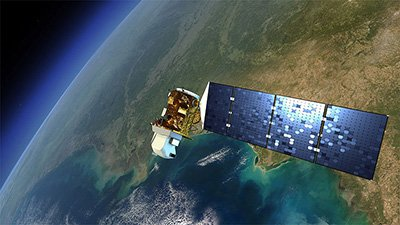

Вам предоставлены данные со спутника **Landsat 8** (https://earth.esa.int/eogateway/missions/landsat-8#data-section)

**Landsat 8**, работает с сенсором OLI/TIRS (Operational Land Imager / Thermal Infrared Sensor), который предоставляет данные с 11 спектральных каналов:


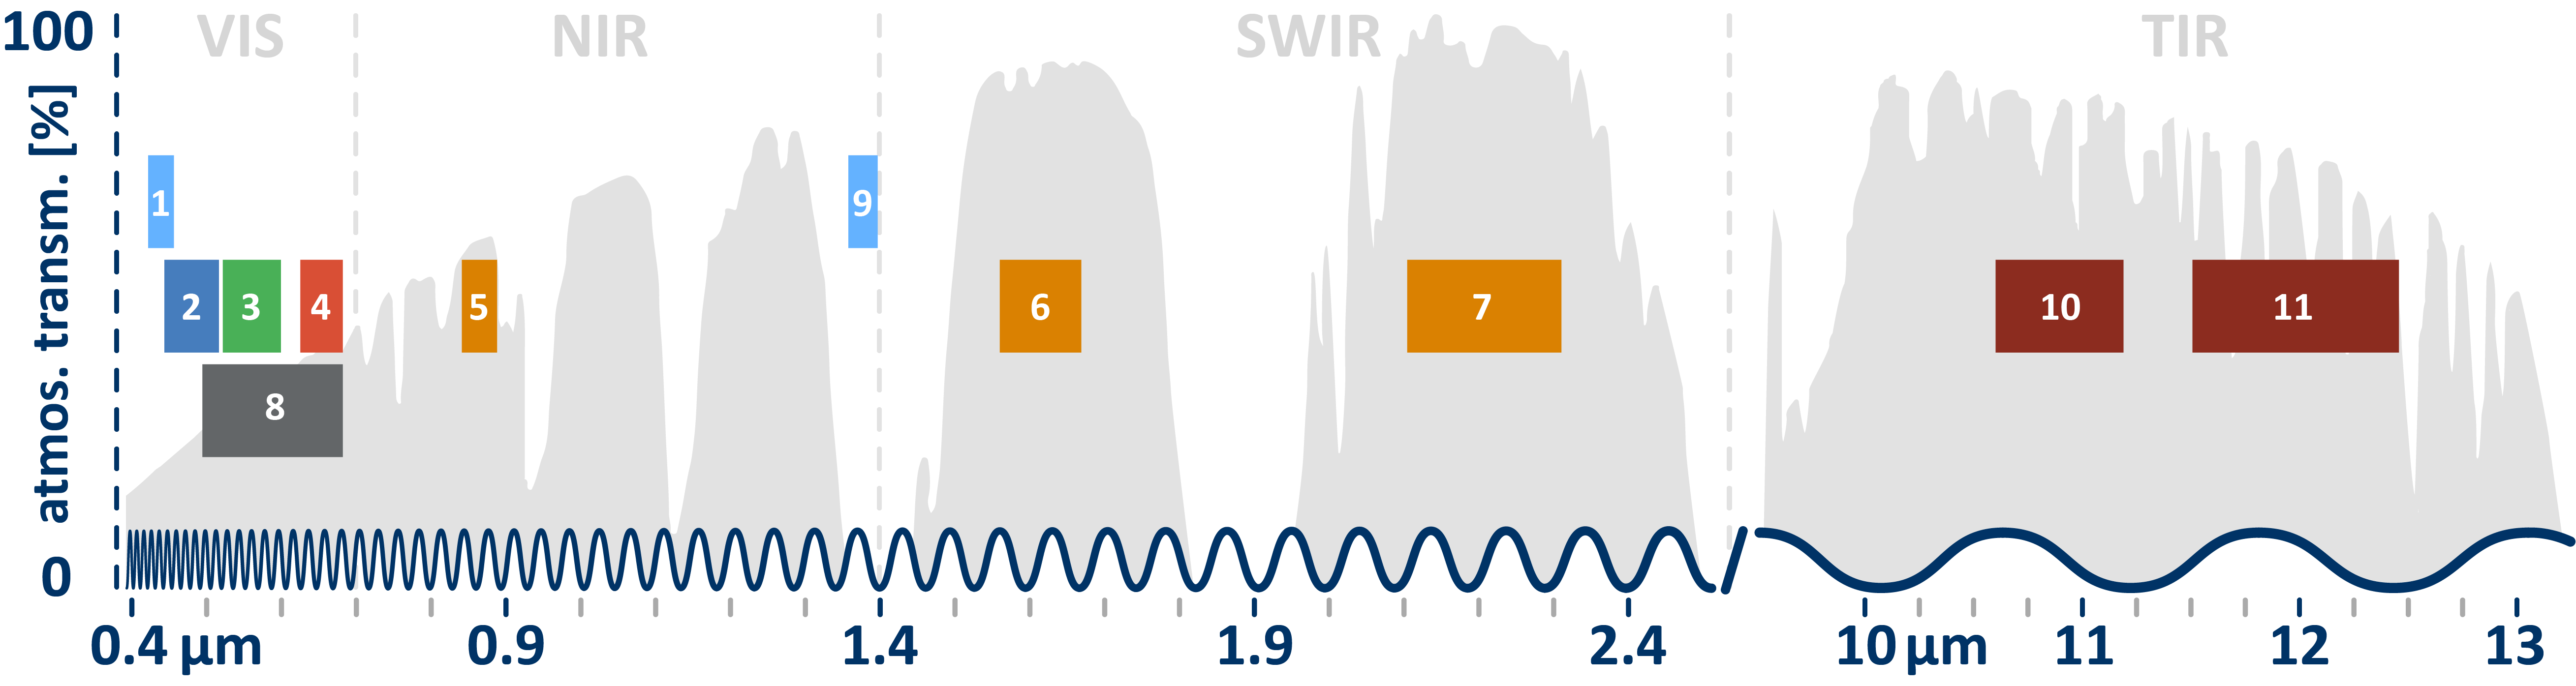





### Часть 1: Визуализация исходных данных
#### 1 (a) Загрузка данных Landsat

In [52]:
rasterdata = loadmat('/Users/user/Yandex.Disk.localized/Лекции/ПУ/Школа/День_2/Optical_assignment/Landsat8.mat')

rasterDN = rasterdata['data']
M, N, dim = rasterDN.shape


#Формирование RGB изображения
RGBraster = np.zeros((M,N,3))
#канал инфракрасного спектра, который используется как красный канал изображения в RGB
RGBraster[...,0] = rasterDN[...,3]
#канал зеленого спектра, который используется как зеленый канал изображения в RGB
RGBraster[...,1] = rasterDN[...,2]
#канал синего спектра, который используется как синий канал изображения в RGB
RGBraster[...,2] = rasterDN[...,1]



#cоздаем  ложноцветное RGB изображение, где канал ближнего инфракрасного спектра используется в качестве основного канала
#Растения сильно отражают ближний инфракрасный свет, и этот канал используется для анализа здоровья и плотности растительности

#Формирование ложноцветного RGB изображения 
RGBrasterIR = np.zeros((M,N,3))
#Канал ближнего инфракрасного спектра (NIR), который используется как красный канал
RGBrasterIR[...,0] = rasterDN[...,4]
#Канал красного спектра, который используется как зеленый канал в этом изображении.
RGBrasterIR[...,1] = rasterDN[...,3]
#Канал синего спектра, который используется как синий канал в этом изображении.
RGBrasterIR[...,2] = rasterDN[...,1]

#функция exposure.equalize_hist выполняет равномерное выравнивание гистограммы для каждого канала. 
#это улучшает контраст изображения, растягивая распределение яркости по всему доступному диапазону пикселей.

#для каждого канала (красного, зеленого и синего) выполняется выравнивание гистограммы
for i in range(3):
    RGBraster[..., i] = exposure.equalize_hist(RGBraster[..., i]) 
    RGBrasterIR[..., i] = exposure.equalize_hist(RGBrasterIR[..., i])
    

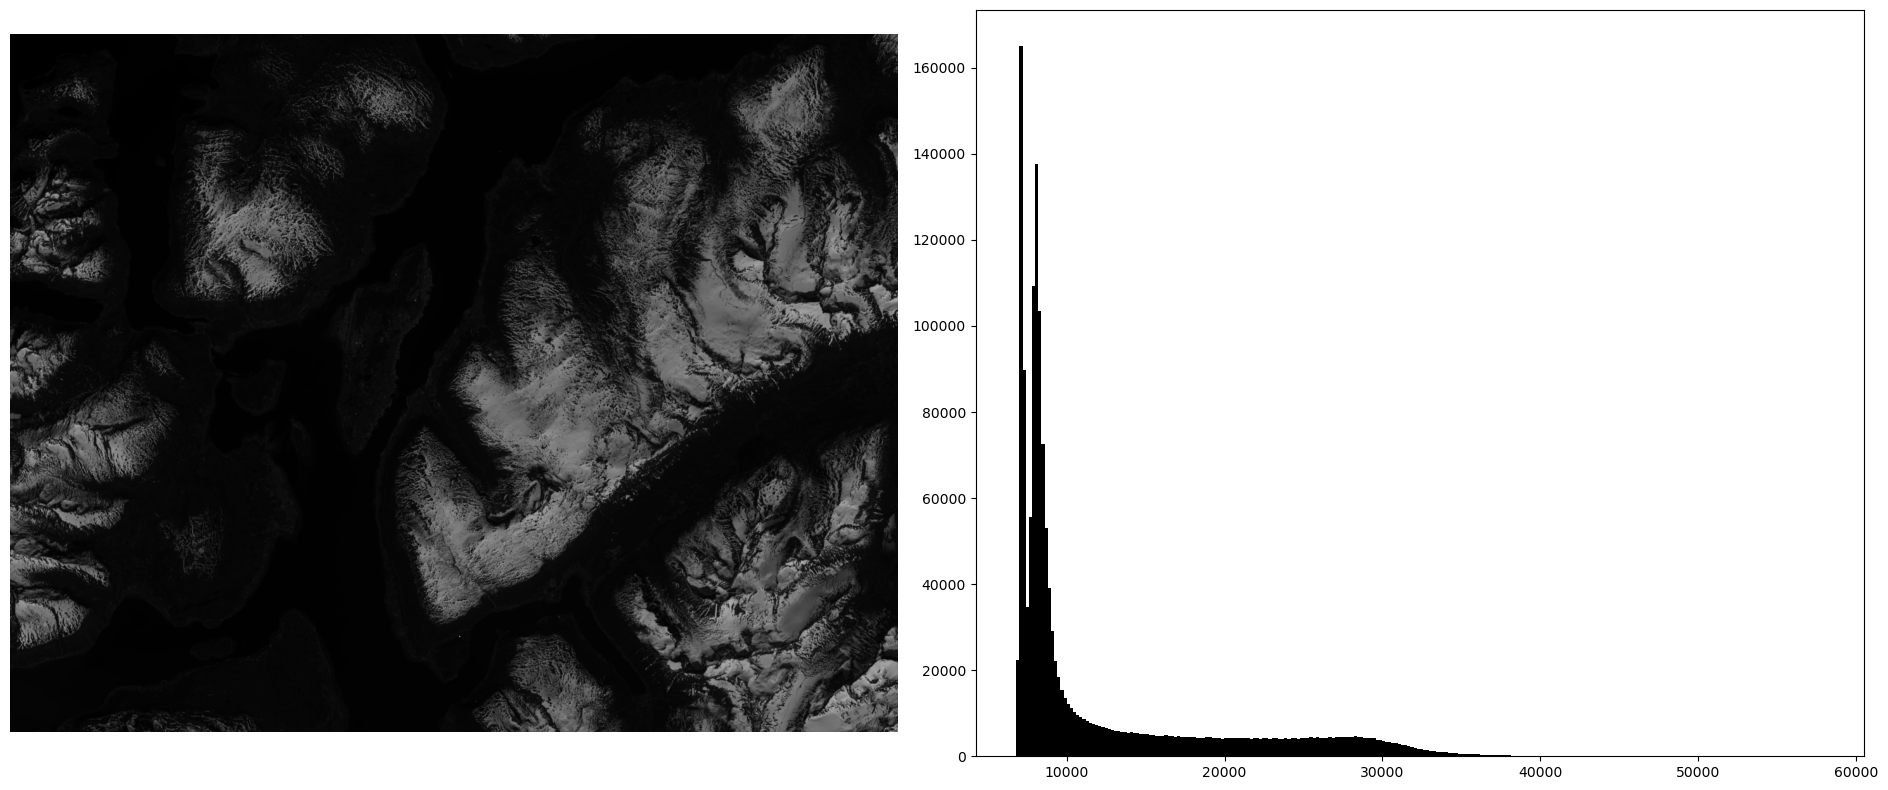

In [53]:
#визуализируем  исходное RGB изображение и строим гистограмму, чтобы исследовать распределение  яркости пикселей 
img = (rasterDN[...,2])
fig, axs = plt.subplots(1, 2, figsize=(19, 8))
ax_img, ax_hist = axs
ax_img.imshow(img, cmap='gray')
ax_img.set_axis_off()
ax_hist.hist(img.ravel(), bins=256, color='black')
fig.tight_layout()
plt.show()

In [1]:
#визуализации второго канала (с выровненной гистограммой)
plt.figure(figsize=(10,10))
plt.imshow(exposure.equalize_hist(RGBraster[...,1]), cmap = 'gray')
plt.title('Histogram equalized, Band 2')
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined

#### Визуализации RGB изображения

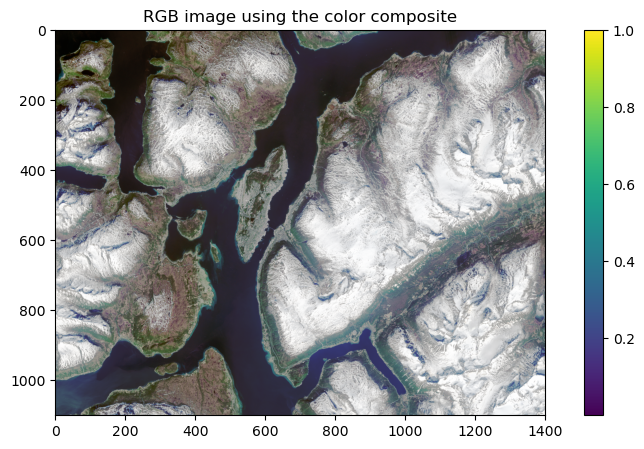

In [55]:
plt.figure(figsize=(10,5))
plt.imshow(RGBraster)
plt.title('RGB image using the color composite')
plt.colorbar()
plt.show()

#### Визуализации ложноцветного RGB изображения

In [56]:
plt.figure(figsize=(10,5))
plt.imshow(RGBrasterIR)
plt.title('RGB image using the color composite')
plt.colorbar()
plt.show()

В чем разница между стандартным RGB и ложноцветным RGB? 

Опишите разницу

### Часть 2: Калибровка

#### 2 (a)

**TOA Radiance** (Радиация на верхней границе атмосферы) — это величина, которая описывает количество электромагнитной энергии (включая видимый свет, инфракрасное излучение и др.), поступающей от объекта на Земле до взаимодействия с атмосферой. Это "сырые" данные, которые регистрирует спутниковый датчик, находясь над атмосферой.





Чтобы получить значения отраженной радиации от поверхности Земли (Surface Reflectance), необходимо учесть влияние атмосферы. Для этого часто используется метод атмосферной коррекции, который позволяет устранить атмосферные и солнечные эффекты.

Чем отличается **TOA Radiance** от **Surface Reflectance**?

 - **TOA Radiance** — энергия, дошедшая до спутника (включая влияние атмосферы).

 - **Surface Reflectance** — энергия, отраженная непосредственно от поверхности Земли (после удаления атмосферных эффектов).


Если упростить: **TOA** — это "как видит спутник", а **Surface Reflectance** — "как есть на самом деле"


**DN** (Digital Numbers) — это "сырые" данные, записанные датчиком спутника. Они не имеют физического смысла (например, 0–255 для 8-битного изображения) и зависят от настроек конкретного датчика.


Метаданные Landsat содержат коэффициенты радиометрической калибровки, которые позволяют напрямую преобразовывать цифровые значения **DN** в **TOA**. Эти коэффициенты включают мультипликативный член (MULT) и аддитивный член (ADD), каждый из которых уникален для отдельной спектрального канала.

Формула калибровки:

TOA = DN * MULT + ADD


### Резюме:

Калибровка **DN → TOA Radiance** превращает "сырые" данные в научно-пригодные величины, которые:

 - Позволяют проводить точные количественные сравнения,

 - Учитывают технические особенности датчика,

 - Служат основой для последующей обработки (атмосферная коррекция, анализ изменений).

#### 2 (b) 
Откалибруем 11 каналов Landsat в TOA

In [57]:
#Код выполняет преобразование сырых данных спутника Landsat (DN) в радиацию на верхней границе атмосферы (TOA)

Q = rasterDN.astype(float)

def TOA_radiance(data):
    # add the multiplicative rescaling factors to the matrix
    M_l = np.zeros(11)
    M_l[0] = 1.2548E-02
    M_l[1] = 1.2795E-02
    M_l[2] = 1.1716E-02
    M_l[3] = 9.9229E-03
    M_l[4] = 6.0213E-03
    M_l[5] = 1.5171E-03
    M_l[6] = 4.9350E-04
    M_l[7] = 1.1177E-02
    M_l[8] = 2.4744E-03
    M_l[9] = 3.3420E-04
    M_l[10] = 3.3420E-04
    
    # do the same to additive rescaling factor 
    A = np.zeros(11)
    A[0] = -62.73803
    A[1] = -63.97628
    A[2] = -58.58069
    A[3] = -49.61426
    A[4] = -30.10648
    A[5] = -7.58533
    A[6] = -2.46749
    A[7] = -55.88732
    A[8] = -12.37200
    A[9] = 0.10000
    A[10] = 0.10000
    
    N,M,d = np.shape(data)
    L = np.zeros([N,M,d])
    Q = data.astype(np.float64)
    for i in range(11):
        L[:,:,i] = M_l[i]*Q[:,:,i]+A[i]
    return L

TOAradiance = TOA_radiance(rasterDN)

TOARadianceRGB = np.zeros(RGBraster.shape)
TOARadianceRGB[...,0] = exposure.equalize_hist(TOAradiance[..., 3])
TOARadianceRGB[...,1] = exposure.equalize_hist(TOAradiance[..., 2])
TOARadianceRGB[...,2] = exposure.equalize_hist(TOAradiance[..., 1])

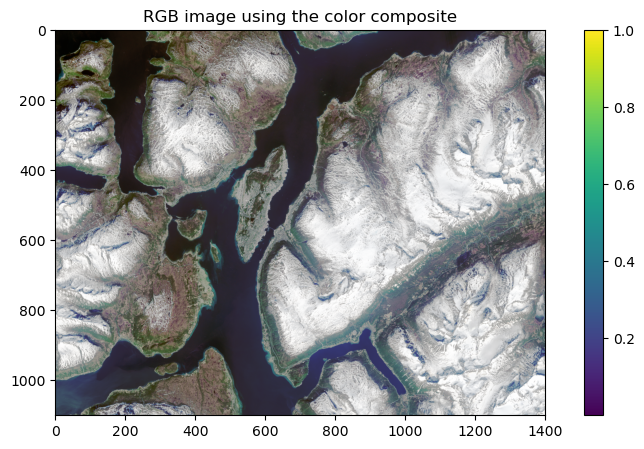

In [58]:
plt.figure(figsize=(10,5))
plt.imshow(TOARadianceRGB)
plt.title('RGB image using the color composite')
plt.colorbar()
plt.show()

### Часть 3: Применение

#### 3 (a) Рассчитайте  индекс NDVI 

#### 3 (b) Рассчитайте индекс NDWI. Используйте результат в комбинации с NDVI для создания маски земля/море


**NDVI** (Normalized Difference Vegetation Index) – Нормализованный разностный вегетационный индекс

**NDVI** применяется для оценки плотности и здоровья растительного покрова. Этот индекс основан на том, что растения активно поглощают красный свет (RED, 0.6–0.7 мкм) и сильно отражают ближний инфракрасный свет (NIR, 0.7–1.1 мкм).


Формула для рассчета: 

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$


Значения NDVI варьируются от -1.0 до 1.0, где отрицательные значения чаще всего указывают на наличие облаков, водной поверхности или снега, а значения, близкие к нулю — на скалы или оголенную почву.

Очень низкие значения NDVI (0.1 и меньше) могут быть связаны с наличием на снимке пустых скалистых участков, песка или снега.

Средние значения (от 0.2 до 0.3) говорят об обнаружении кустарников и лугов, а высокие значения (от 0.6 до 0.8) — лесов умеренного и тропического пояса.



**NDWI** применяется для выделения водных объектов (реки, озера, моря) и оценки водосодержания в растительности. Он основан на соотношении ближнего инфракрасного (NIR) и среднеинфракрасного (SWIR, 1.2–2.5 мкм) излучения.

Формула для рассчета:

$$
NDWI = \frac{NIR - SWIR}{NIR + SWIR}
$$

 - **NDWI** < -0.45: Водные объекты (озера, реки, океан).


0 и выше: Водные тела (озера, реки, океаны).
0.0 - 0.2: Влажные территории, такие как болота, влажные почвы, заболоченные участки.
0.0 и ниже: Сухие участки, такие как земля, скалы, пустыни, неводные экосистемы.


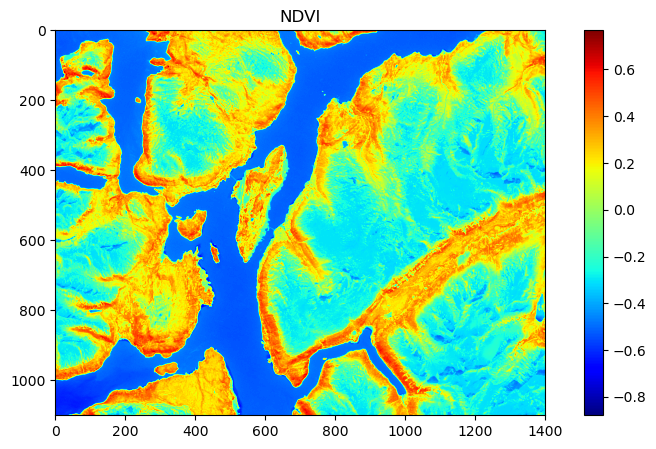

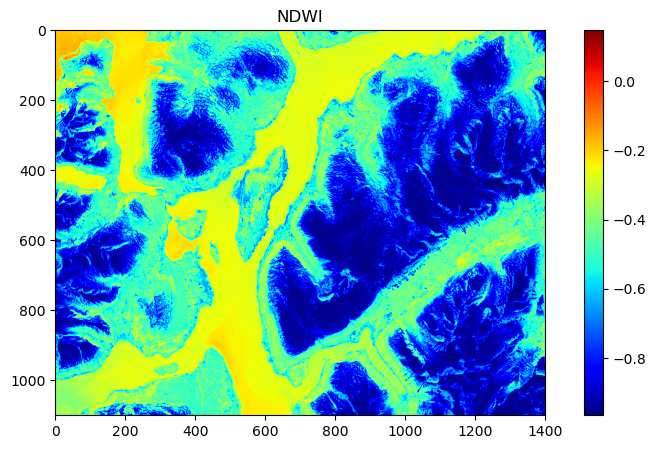

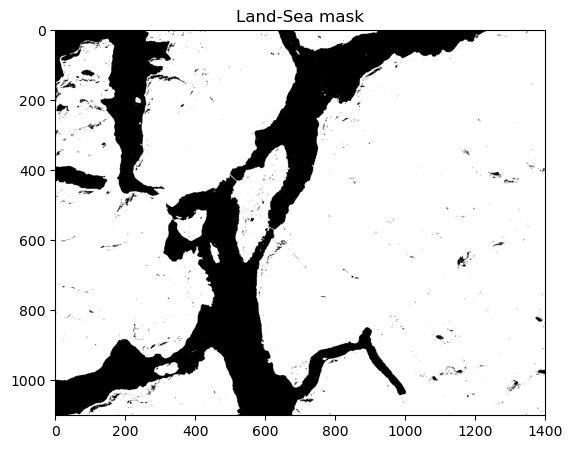

In [42]:
#Расчет NDVI
NDVI = (TOAradiance[..., 4] - TOAradiance[...,3])/(TOAradiance[..., 4] + TOAradiance[...,3])
#Расчет NDWI
NDWI = (TOAradiance[..., 9] - TOAradiance[...,3])/(TOAradiance[..., 9] + TOAradiance[...,3])


landmask = ((NDVI > -0.45)*(NDWI < -0.3))

plt.figure(figsize=(10,5))
plt.imshow(NDVI, cmap='jet')
plt.title('NDVI')
plt.colorbar()
plt.figure(figsize=(10,5))
plt.imshow(NDWI, cmap='jet')
plt.colorbar()
plt.title('NDWI')
plt.figure(figsize=(10,5))
plt.imshow(landmask, cmap='gray')
plt.title('Land-Sea mask')
plt.show()

#### 3 (c) 
Последние две полосы Landsat 8 также полезны. Мы можем установить связь между яркостной температурой и температурой поверхности.



**Яркостная температура** (Brightness Temperature)

 - Это температура, рассчитанная на основе интенсивности теплового излучения, зафиксированного спутниковым сенсором в тепловом инфракрасном диапазоне (TIR).
 - Она измеряется в Кельвинах (K) и получается с помощью уравнения Планка.
 - Однако, она не отражает реальную температуру поверхности, так как на нее влияет атмосферное поглощение, отражение и излучательная способность (эмиссивность) поверхности.
 
 
Формула для преобразования радиации ТОА (TOA radiance) в яркостную температуру:

$$
T_B = \frac{K_2}{\ln\left(\frac{K_1}{L} + 1\right)}
$$


**Температура поверхности** (Surface Temperature) 


 - Это реальная физическая температура земной поверхности (воды, почвы, растительности).
 - Она может быть рассчитана из яркостной температуры с учетом атмосферного влияния и эмиссивности материала.
 - Именно температура поверхности важна для климатических исследований, анализа влажности почвы и мониторинга лесных пожаров.
 
 
 Эмпирическая формула для расчета температуры поверхности моря:

$$
SST = 5.1424 + 0.9558 \cdot T_{10} + 0.8365 \cdot (T_{10} - T_{11})
$$

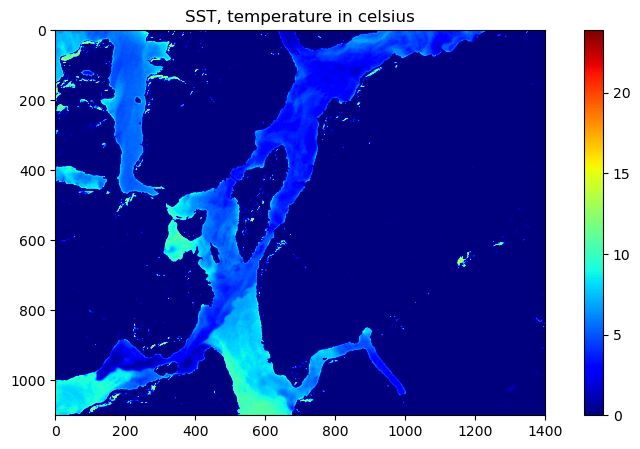

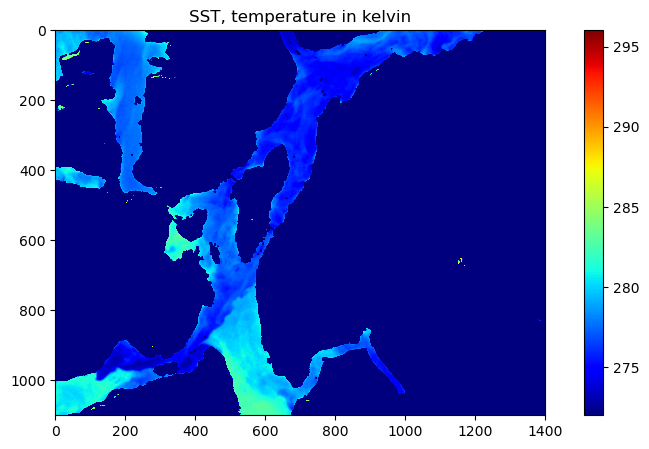

In [59]:
sea_mask = 1 - landmask

#Константы K1 и K2 — это калибровочные коэффициенты для тепловых инфракрасных каналов (Band 10 и Band 11) Landsat 8.

K1_CONSTANT_BAND_10 = 774.89 
K1_CONSTANT_BAND_11 = 480.89 

K2_CONSTANT_BAND_10 = 1321.08 
K2_CONSTANT_BAND_11 = 1201.14



def TOA_BT(data,K1,K2):

    T = K2/(np.log((K1/data)+1))
    return T


#Рассчитываем T10 и T11 - яркостную температуру в каналах 10 и 11
T10 = TOA_BT(TOAradiance[:,:,9],K1_CONSTANT_BAND_10,K2_CONSTANT_BAND_10)
T11 = TOA_BT(TOAradiance[:,:,10],K1_CONSTANT_BAND_11,K2_CONSTANT_BAND_11)

#Расчет температуры поверхности моря в цельсиях и кельвинах
SST_celsius = (5.1424 + 0.9558 * T10 + 0.8365*(T10 - T11))-272.15 
SST_kelvin = (5.1424 + 0.9558 * T10 + 0.8365*(T10 - T11))

#add seamask on the SST in celsius 
SST_sea_mask_celsius = (SST_celsius*sea_mask)
plt.figure(figsize=(10,5))
plt.imshow(SST_sea_mask_celsius,cmap='jet',vmin=0)
plt.colorbar()
plt.title('SST, temperature in celsius')

#add seamask on the SST in kelvin
SST_sea_mask_kelvin = (SST_kelvin*sea_mask)
plt.figure(figsize=(10,5))
plt.imshow(SST_sea_mask_kelvin,cmap='jet',vmin = 272)
plt.colorbar()
plt.title('SST, temperature in kelvin')
plt.show()